<a href="https://colab.research.google.com/github/MarkStocksUK/White_Wine_Analysis/blob/main/White_Wine_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#White Wine Quality Prediction


---



In [5]:
pip install pandas

Importing initial libraries and our checking our input directory.

In [6]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

print(os.listdir("sample_data"))

['README.md', 'anscombe.json', 'winequality-white.csv', 'mnist_train_small.csv', 'california_housing_test.csv', 'mnist_test.csv', 'california_housing_train.csv']


Read the csv data into a dataframe

In [7]:
wwdata = pd.read_csv("sample_data/winequality-white.csv")

A quick look at the first couple of rows of data

In [8]:
print(wwdata.head(2))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   

   free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  \
0                 45.0                 170.0    1.001  3.0       0.45   
1                 14.0                 132.0    0.994  3.3       0.49   

   alcohol  quality  
0      8.8        6  
1      9.5        6  


Lets investigate the dataframe and then look at the descriptive statisics of the columns.

In [9]:
wwdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [10]:
wwdata.describe()


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

We have some big variances in the min and max on some fields (***residual sugar***, ***free sulfur dioxide***, ***total sulfur dioxide*** are three standout examples).\
Lets check for any missing data.

<Axes: >

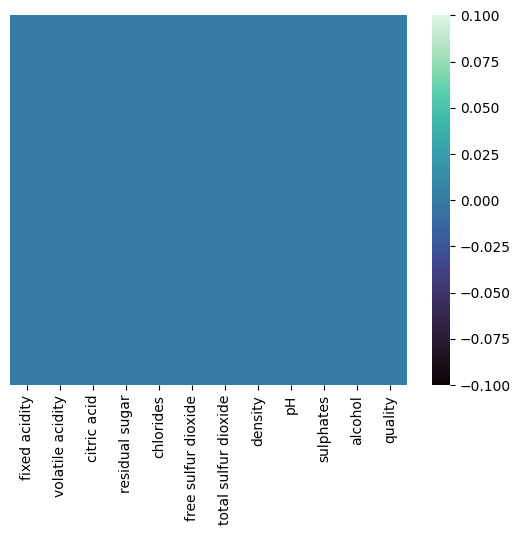

In [11]:
sns.heatmap(wwdata.isnull(), yticklabels=False, cbar=True, cmap='mako')

In [12]:
wwdata.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

No signs of any missing data or nulll values.\
Now lets check for any outliers. We can use box plots for this.

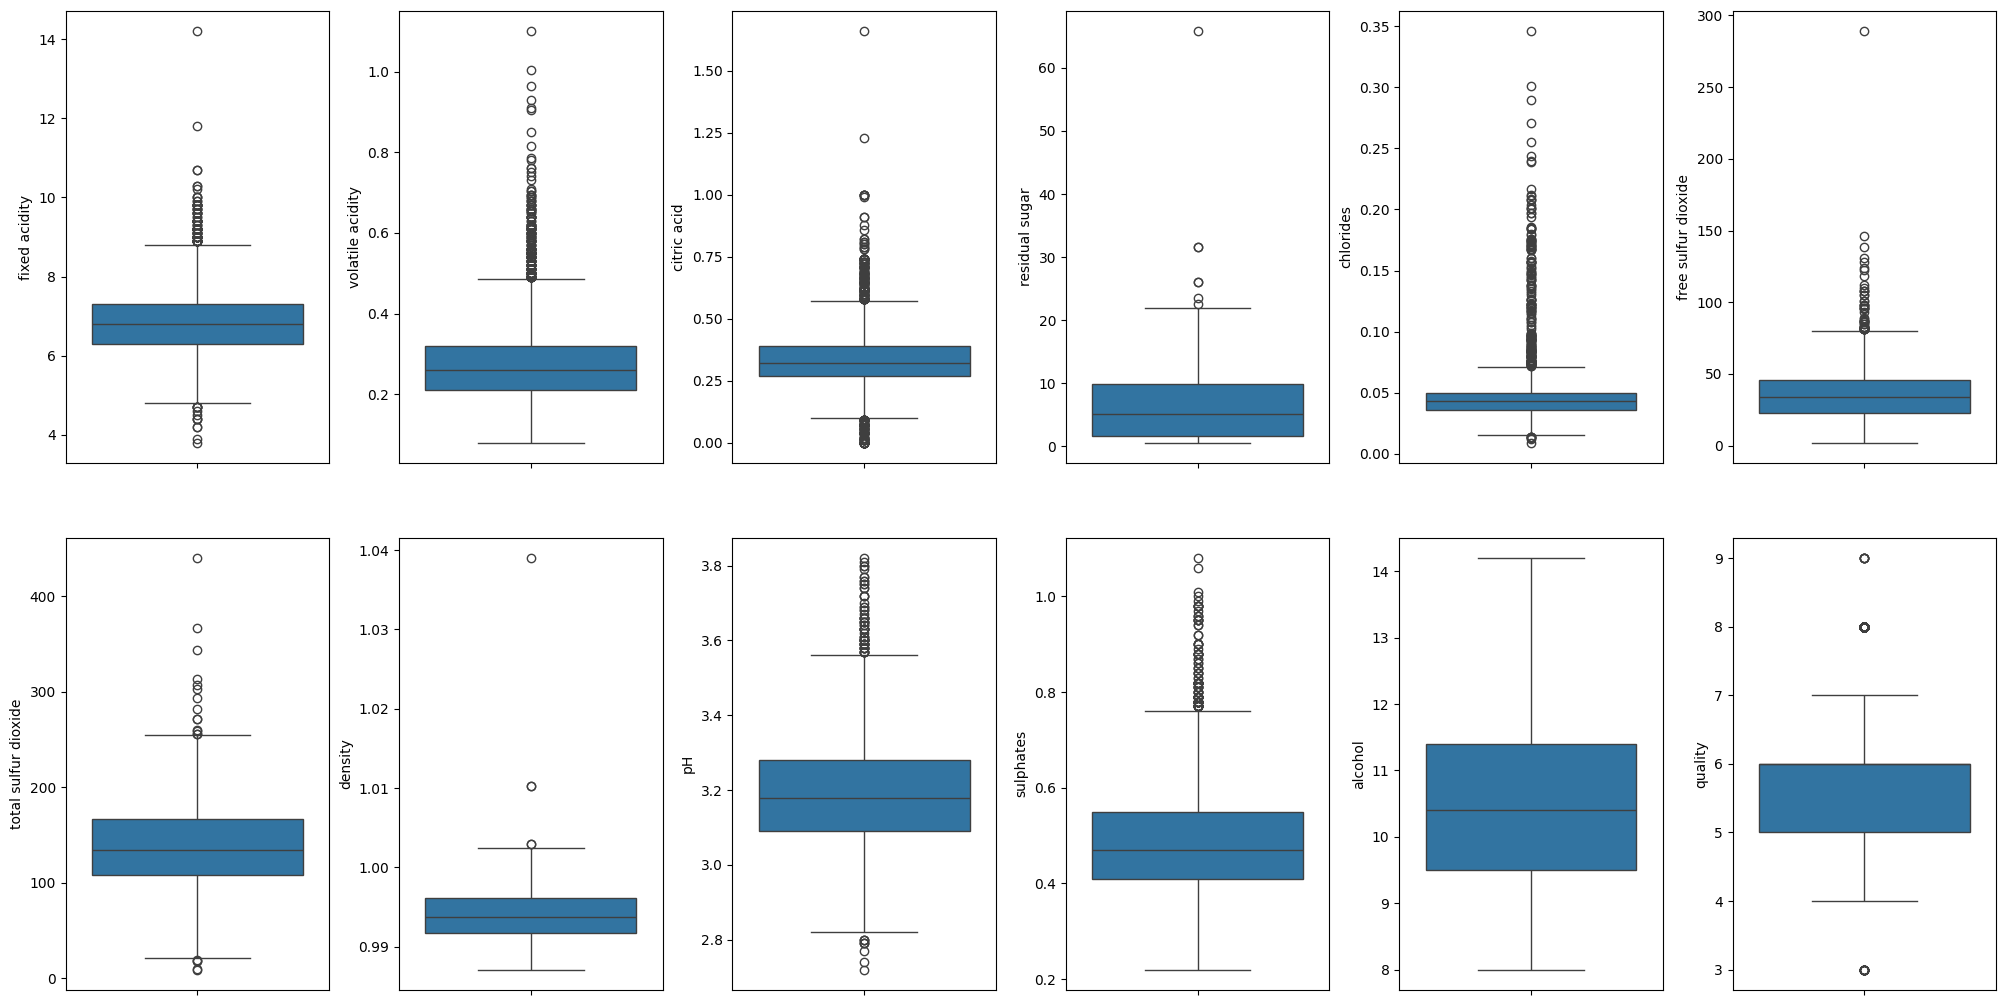

In [13]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for mycol, value in wwdata.items():
  sns.boxplot(y=mycol, data=wwdata, ax=ax[index])
  index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

Theres LOTS of outliers in our data so we need to clean these up. We will do this by adjusting outliers to be at the caps of each column. We remove our target column from this process.

In [15]:
import warnings
warnings.filterwarnings("ignore")

def modify_outliers(df):
  df1 = df.copy()
  df = df._get_numeric_data()
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1

  lowerbound = Q1 -(1.5 * IQR)
  upperbound = Q3 +(1.5 * IQR)

  for col in df.columns:
    if col == 'quality':
      continue
    for i in range(0,len(df[col])):
        if df[col][i] < lowerbound[col]:
            df[col][i] = lowerbound[col]

        if df[col][i] > upperbound[col]:
            df[col][i] = upperbound[col]

  for col in df.columns:
      df1[col] = df[col]

  return(df1)

wwdata = modify_outliers(wwdata)

Rechecking the boxplots to see if the adjustments have worked.

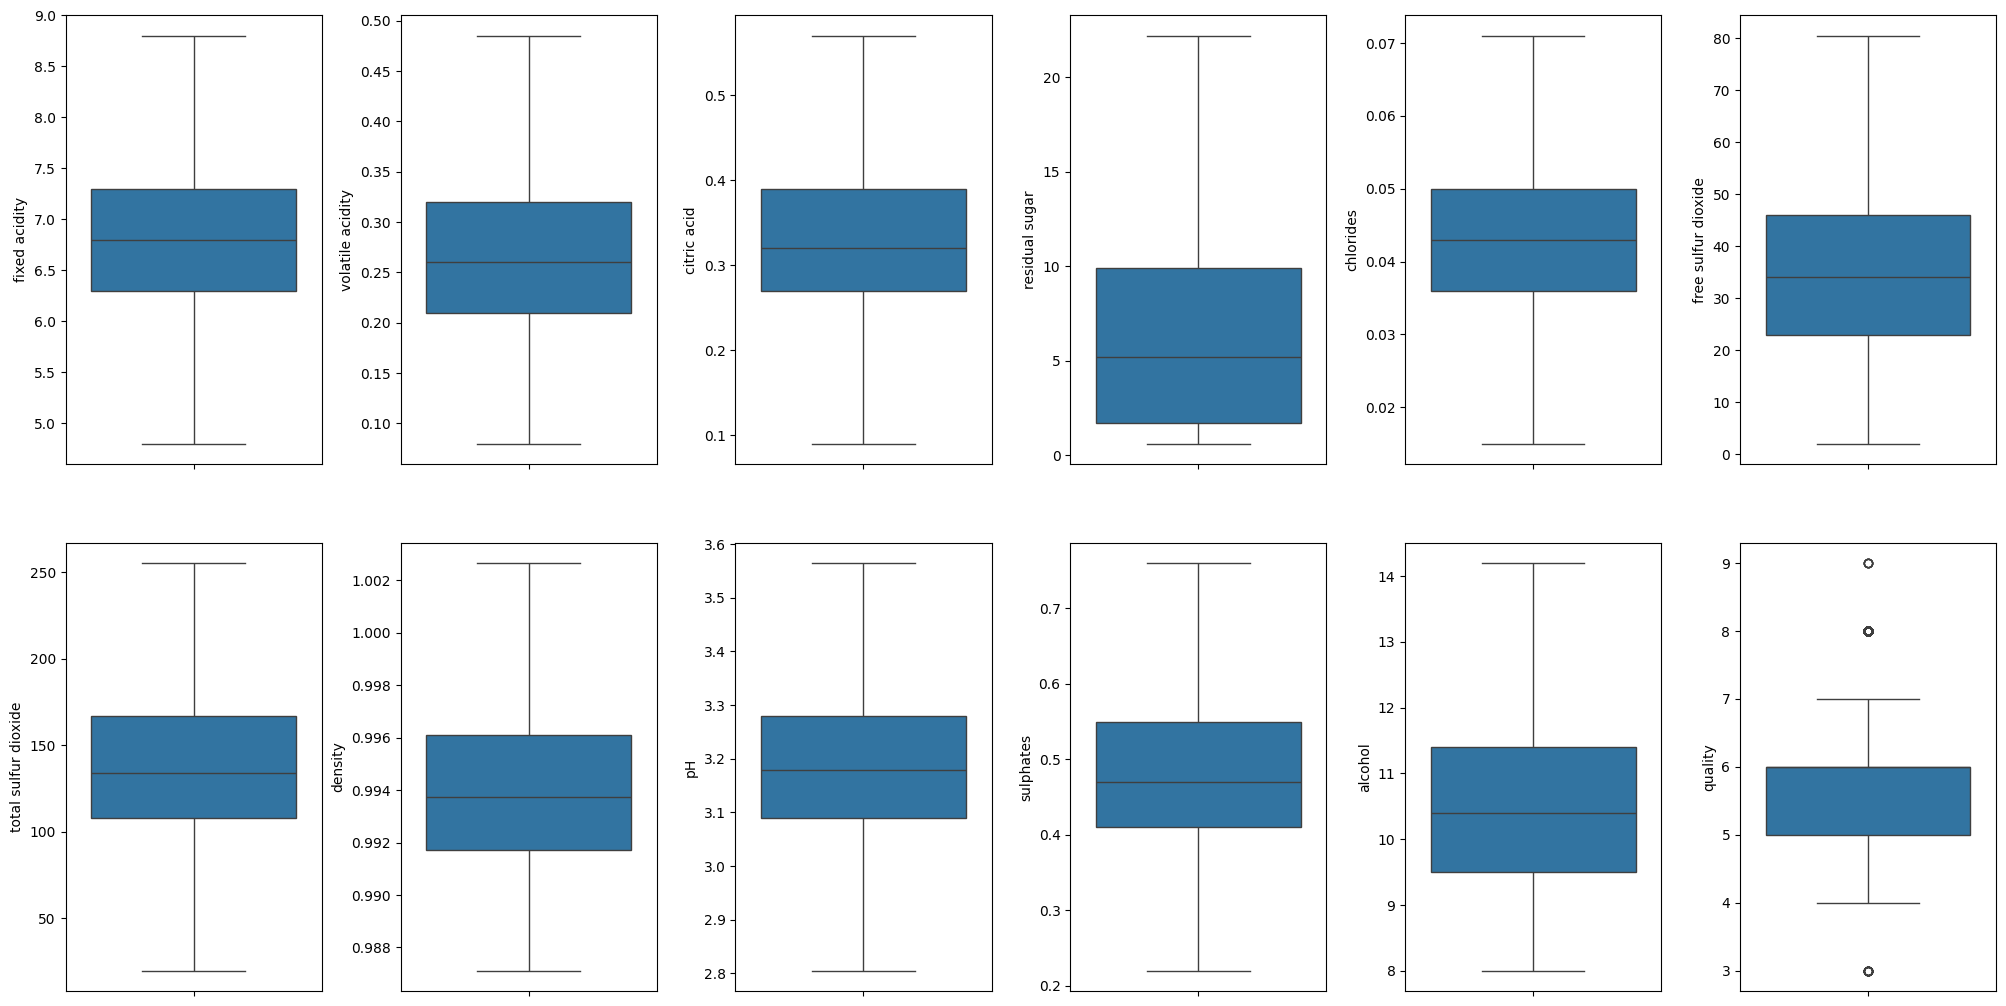

In [16]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for mycol, value in wwdata.items():
  sns.boxplot(y=mycol, data=wwdata, ax=ax[index])
  index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

Great, the outliers are now dealt with.

We will be looking to predict the ***quality*** of the wine, so lets investigate the data in that variable.

In [17]:
wwdata['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

<Axes: xlabel='quality', ylabel='count'>

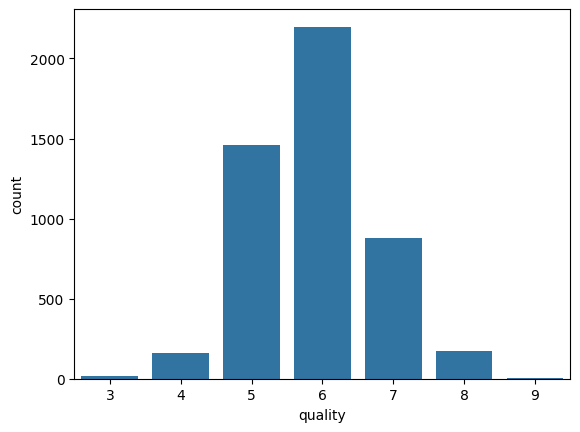

In [18]:
sns.countplot(x='quality', data=wwdata)

There are no wines rated at 1, 2 or 10.\
The majority of wines, score in the 5-7 range.\
Suggesting we can split the wines into 3 bands;


*   4 or lower = "Bad"
*   5-7 = "Average"
*   8 or higher = "Good"

# Finding correlations
lets start with some pairplots

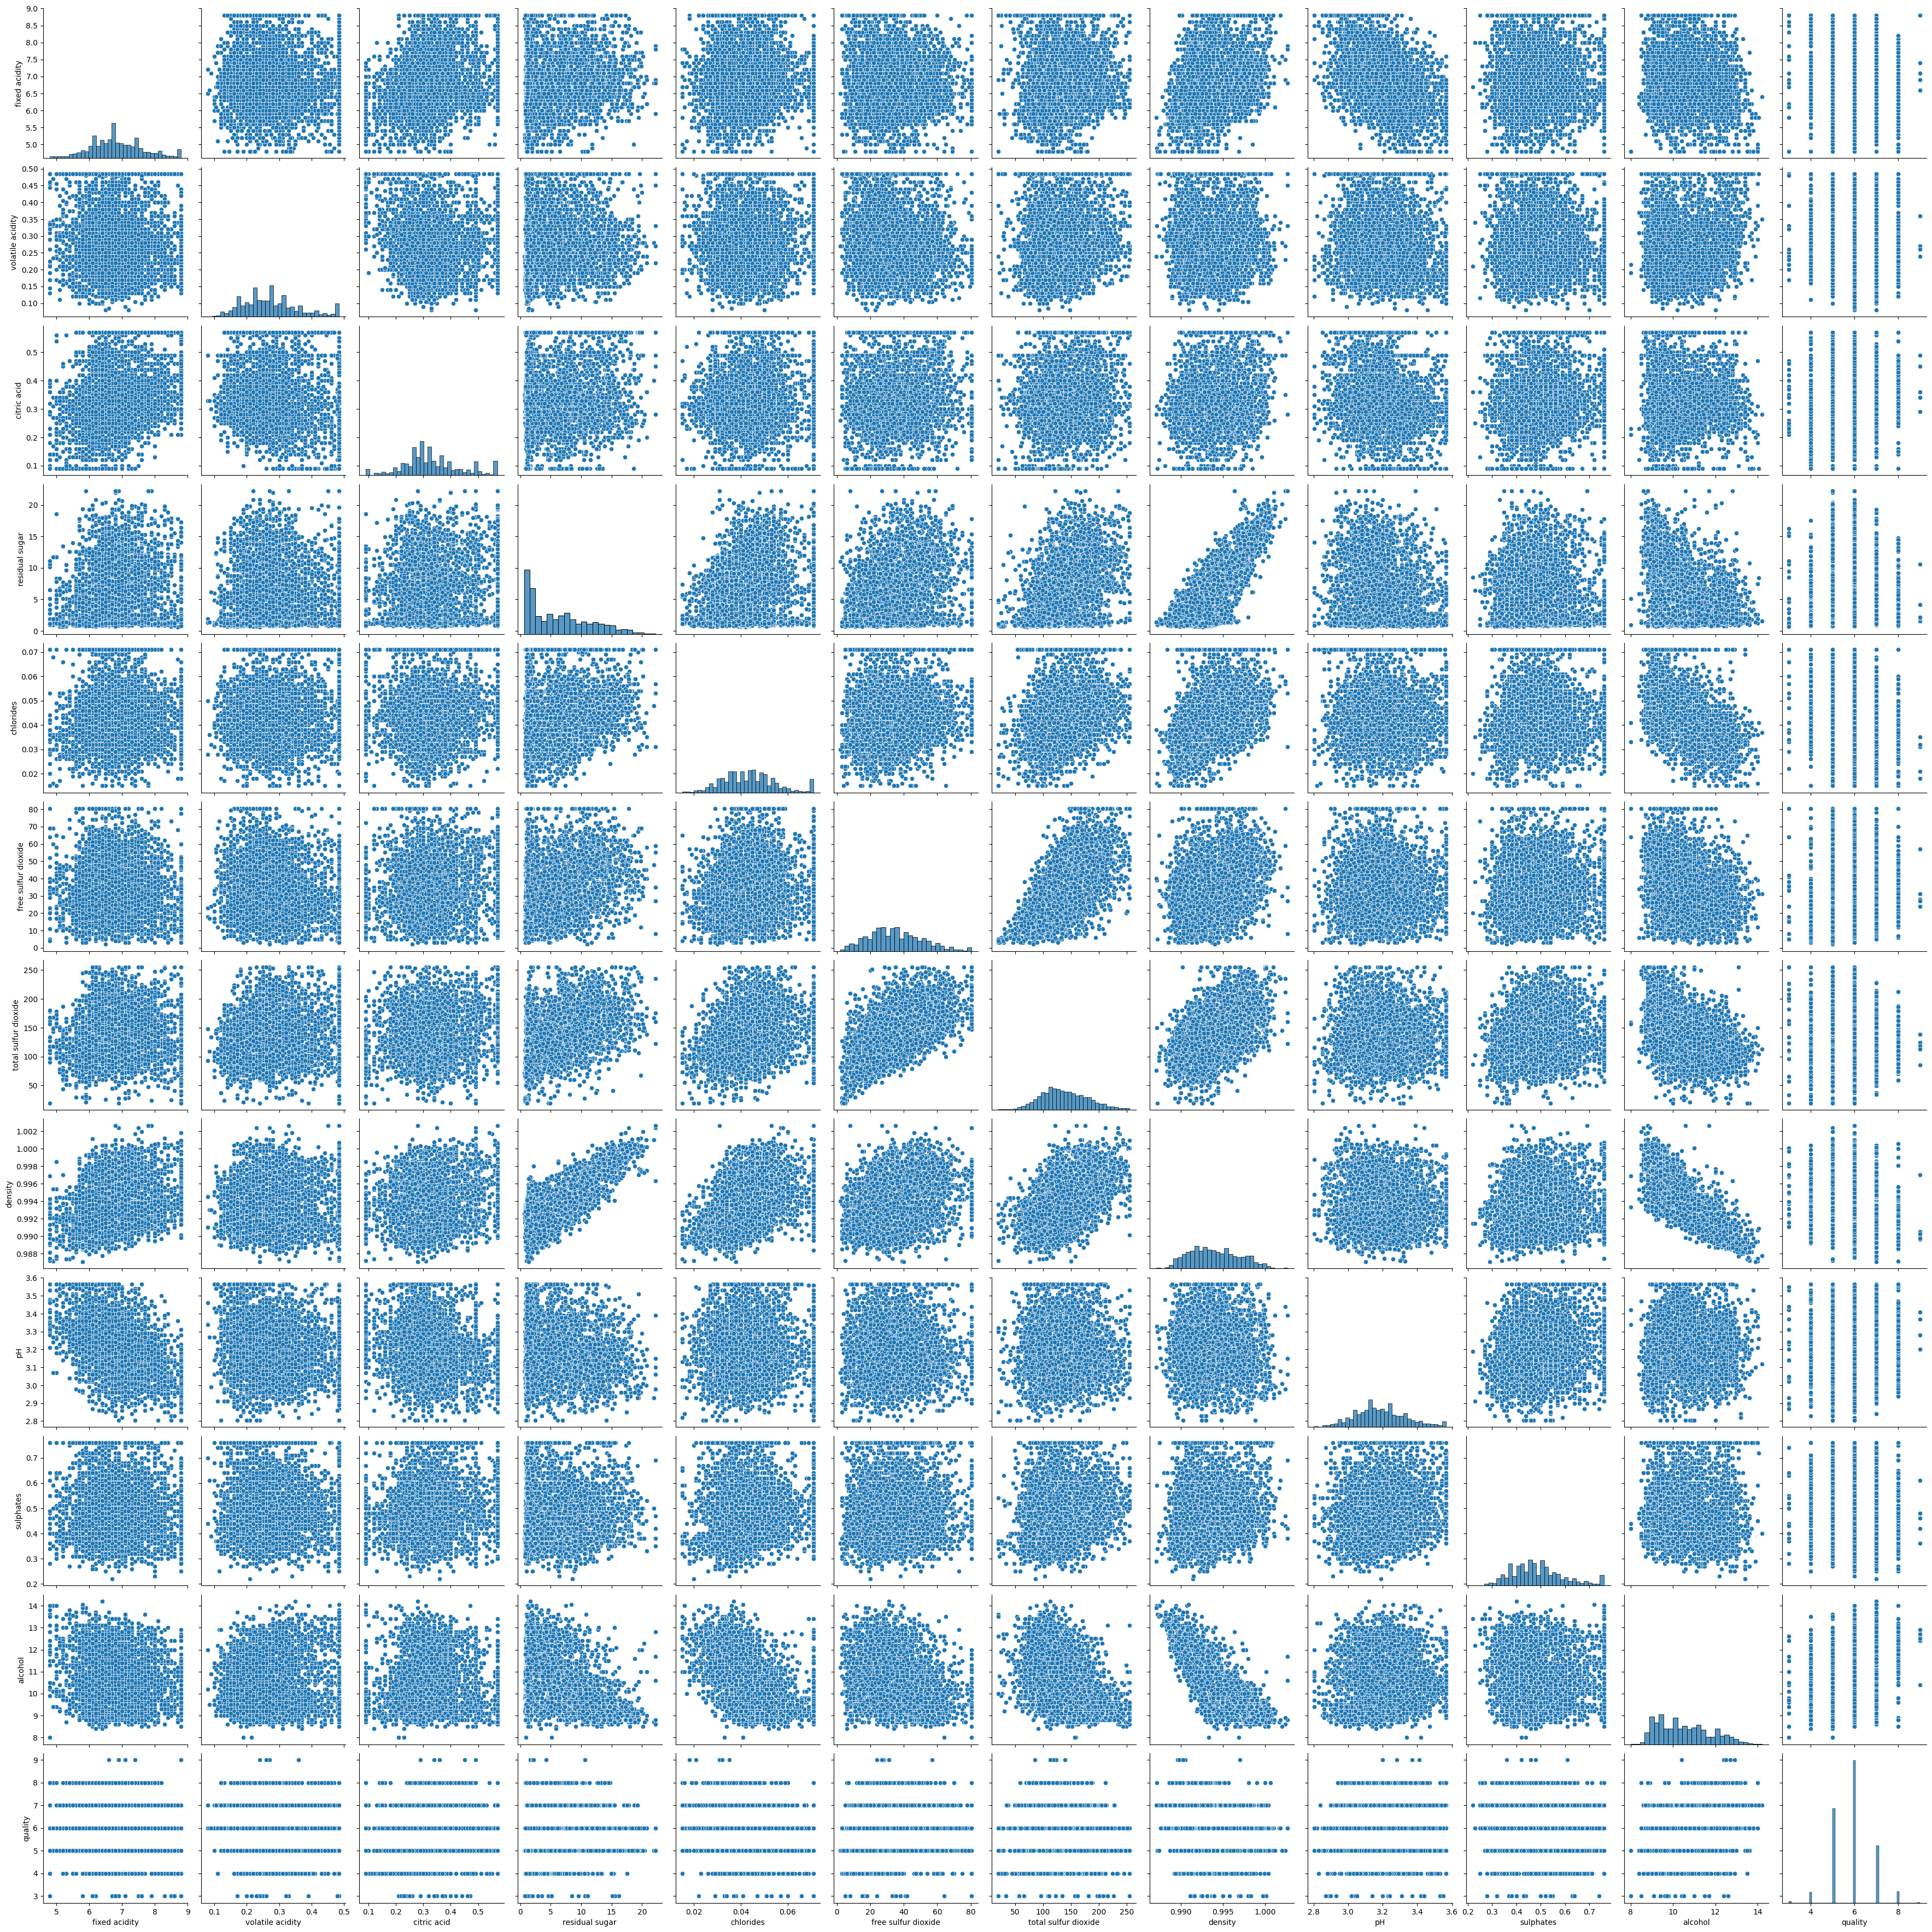

In [19]:
sns.pairplot(data=wwdata, height=3)

<Axes: >

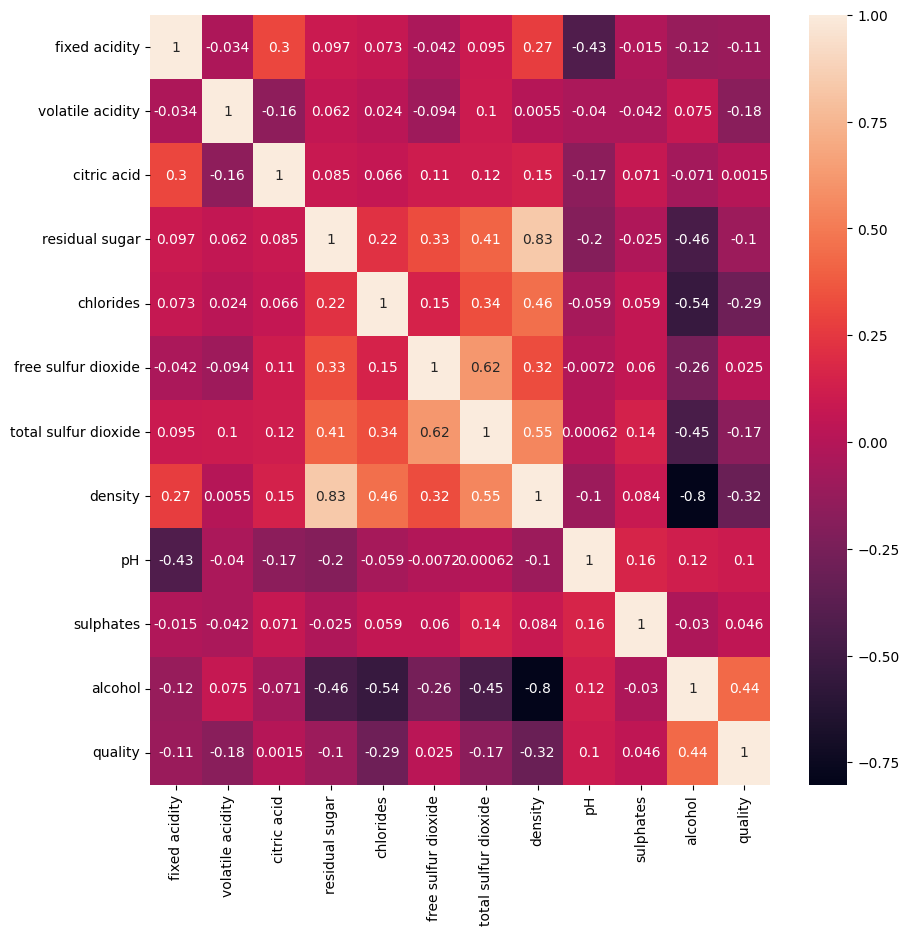

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(data=wwdata.corr(), annot=True)

* The strongest positive correlation is between ***density*** and ***residual sugar***.\
* The strongest negative correlation is between ***density*** and ***alcohol***. \

* The ***alcohol*** variable has the strongest correlation with our target ***quality*** (0.44). \

Lets look at the box plot for that relationship.

<Axes: xlabel='quality', ylabel='alcohol'>

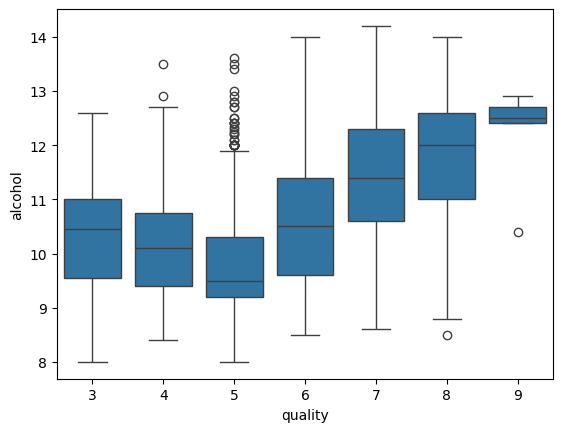

In [21]:
sns.boxplot(data=wwdata, x='quality', y='alcohol')

We can see wines with a higher ***quality*** score tend to have a higher ***alcohol*** content.

# Modelling
We need to create a new column to hold the bad, average, good bandings based on ***quality***.

In [22]:
#create an empty list called Banding
banding=[]
for qval in wwdata['quality']:
    if qval >=1 and qval <=4:
      banding.append('bad')
    elif qval>=5 and qval <=7:
      banding.append('average')
    elif qval>=8 and qval <=10:
      banding.append('good')

wwdata['Banding']=banding

Some quick checks on the new Bandings column

In [23]:
wwdata.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Banding'],
      dtype='object')

In [24]:
wwdata['Banding'].unique()

array(['average', 'good', 'bad'], dtype=object)

In [25]:
Counter(wwdata['Banding'])

Counter({'average': 4535, 'good': 180, 'bad': 183})

This is very imbalanced dataset, 92% of wines the wines are in the "average" banding, so our model could just predict "average" everytime and still be 92% accurate. We will need to rebalance the data later.

First lets split our data into our features (x) and target (y).

In [26]:
x = wwdata.drop(['quality','Banding'], axis=1)
y = wwdata['Banding']

In [27]:
x.head(2)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   

   free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  alcohol  
0                 45.0                 170.0    1.001  3.0       0.45      8.8  
1                 14.0                 132.0    0.994  3.3       0.49      9.5

In [28]:
y.head(2)

0    average
1    average
Name: Banding, dtype: object

As mentioned earlier we need to rebalance the data by oversampling the "bad" and "good" wines.

In [29]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)
# transform the dataset
x, y = oversample.fit_resample(x, y)

Counter(y)

Counter({'average': 4535, 'good': 4535, 'bad': 4535})

We split our data into train and test datasets

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

Check the sizing of the new datasets

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10203, 11)
(10203,)
(3402, 11)
(3402,)


# Model training, confusion matrix and accuracy scores.
First we will try logistical regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
lr = LogisticRegression(max_iter=1000000)
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print('Confusion Matrix')
print(lr_conf_matrix)
print()

print('Classification report')
print(classification_report(y_test,lr_predict))

Confusion Matrix
[[492 247 374]
 [266 857  51]
 [209  37 869]]

Classification report
              precision    recall  f1-score   support

     average       0.51      0.44      0.47      1113
         bad       0.75      0.73      0.74      1174
        good       0.67      0.78      0.72      1115

    accuracy                           0.65      3402
   macro avg       0.64      0.65      0.64      3402
weighted avg       0.65      0.65      0.65      3402



65% Accuracy using the Logistic Regression model, and it required increasing the iterations to get convergence. Even then the confusion matrix doesn't look good with lots of values outside of the diagonal, suggesting it's getting lots of things wrong.

Lets try a Decision Tree Model.

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_predict=dt.predict(x_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predict)
dt_acc_score = accuracy_score(y_test, dt_predict)
print('Confusion Matrix')
print(dt_conf_matrix)
print()
print('Classification report')
print(classification_report(y_test, dt_predict))

Confusion Matrix
[[ 943   74   96]
 [  64 1106    4]
 [  49    2 1064]]

Classification report
              precision    recall  f1-score   support

     average       0.89      0.85      0.87      1113
         bad       0.94      0.94      0.94      1174
        good       0.91      0.95      0.93      1115

    accuracy                           0.92      3402
   macro avg       0.91      0.91      0.91      3402
weighted avg       0.91      0.92      0.91      3402



This is looking better, more values along the diagonal and an accuracy score of 92% for the Decision Tree model.

Now lets try Random Forest.

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict=rf.predict(x_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print('Confusion Matrix')
print(rf_conf_matrix)
print()
print('Classification report')
print(classification_report(y_test, rf_predict))

Confusion Matrix
[[1036   32   45]
 [  15 1159    0]
 [   8    0 1107]]

Classification report
              precision    recall  f1-score   support

     average       0.98      0.93      0.95      1113
         bad       0.97      0.99      0.98      1174
        good       0.96      0.99      0.98      1115

    accuracy                           0.97      3402
   macro avg       0.97      0.97      0.97      3402
weighted avg       0.97      0.97      0.97      3402



97% accuracy using Random Forest, another improvement on the Decision Tree model and the confusion matrix is looking good too.

Finally lets try ExtraTrees.

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier()
et.fit(x_train, y_train)
et_predict=et.predict(x_test)
et_conf_matrix = confusion_matrix(y_test, et_predict)
et_acc_score = accuracy_score(y_test, et_predict)
print('Confusion Matrix')
print(et_conf_matrix)
print()
print('Classification report')
print(classification_report(y_test, et_predict))

Confusion Matrix
[[1044   31   38]
 [  14 1160    0]
 [   3    0 1112]]

Classification report
              precision    recall  f1-score   support

     average       0.98      0.94      0.96      1113
         bad       0.97      0.99      0.98      1174
        good       0.97      1.00      0.98      1115

    accuracy                           0.97      3402
   macro avg       0.97      0.97      0.97      3402
weighted avg       0.97      0.97      0.97      3402



98% accuracy using the Extra Trees model, further improvements, and an improved confusion matrix again.

Let's look closer at the confusion matrix. We will normalise the results to percentages to make it easier to compare classes and display it as a heatmap.

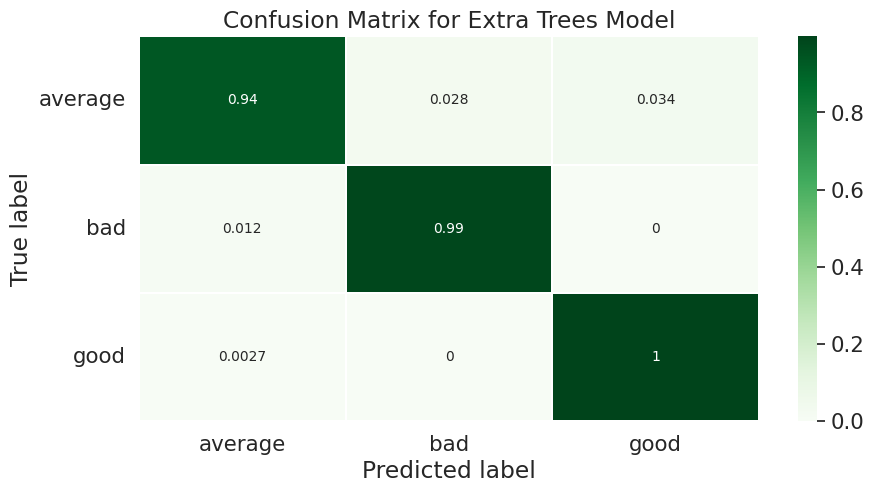

In [36]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, et_predict)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['average','bad', 'good']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Extra Trees Model')
plt.show()

Now we can see that the Extra Trees model is excellent at classifying good wines. It's worst performance is when it incorrectly classifies average wines as bad 3% of the time.

Finally, what are the most import of the features in the model.

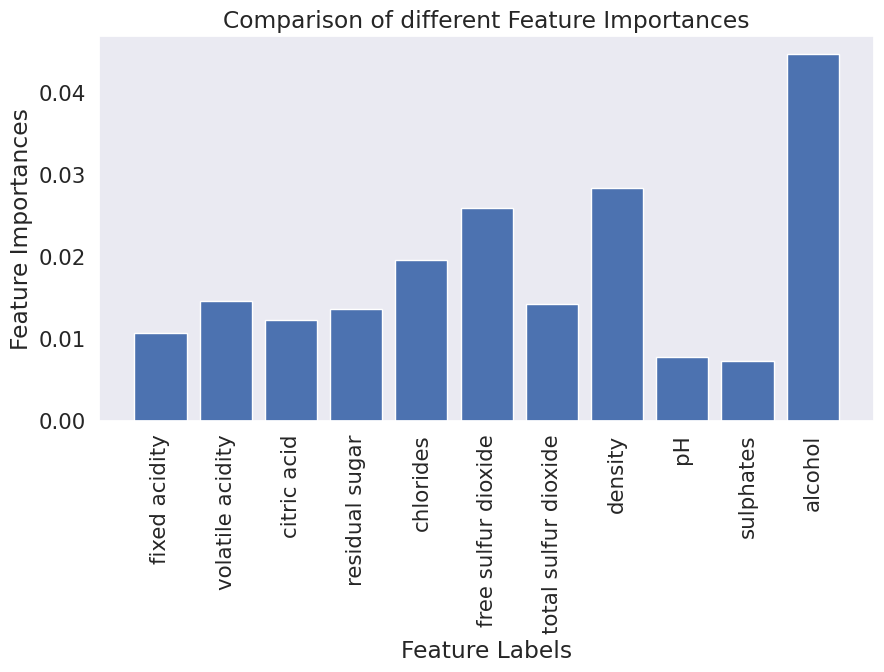

In [37]:
feature_importance = et.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in et.estimators_], axis = 0)

fig, ax = plt.subplots(1, figsize = (10, 5))
ax.grid()
plt.xticks(rotation =90)

plt.bar(x.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')

plt.show()

We can see that alcohol is the most important feature in the model. This backs up what was identified during our early analysis.

#Conclusion
Alcohol is the main indicator variable for the quality of a white wine. Given the phsyiochemical properties of a wine, the ExtraTreesClassifier model is able to predict with 98% accuracy whether a wine will be "bad", "average", or "good".